# 量子計算入門ハンズオン (1回目)
本ノートブックをgoogle driveに保存した後、ブラウザ上のgoogle colaboratoryでこのノートブックを開いてください。(ローカル環境で動かしたい方はそれでもOKです)

## QURI Partsの紹介

量子計算を記述するためのライブラリは、IBMのQiskit, Googleのcirqなど様々なものが存在しますが、それぞれ記法が異なるために各社の実機を使い分けたい場合などにコードを書きなおす必要があります。quri_partsはこうしたSDK間の差異を吸収し、共通したインタフェースで記述、実行できることを目的としてQunaSysが開発しているオープンソースのライブラリで、quri_partsで記述したコードはqiskitなどのほかのライブラリの処理にコンバートすることが可能です。

本講義では、基本的にこのquri_partsを用いて処理の実装を行いますが、状況に応じてqiskitなどを組み合わせて解説することもあります。

## 環境構築
以下のセルを実行で環境構築ができます。

$$
\renewcommand{\ket}[1]{\left| #1 \right\rangle}
\renewcommand{\bra}[1]{\left\langle #1 \right|}
\renewcommand{\braket}[2]{\left\langle #1 \middle| #2 \right\rangle}
$$

In [1]:
!python -m pip install numpy matplotlib qiskit pylatexenc quri_parts quri_parts[qiskit] quri_parts[qulacs] scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 13.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2

In [2]:
import numpy as np
from quri_parts.qiskit.circuit import convert_circuit #quri_pats -> qiskitの回路オブジェクトに変換する関数
from quri_parts.circuit import QuantumCircuit
from qiskit.quantum_info import Statevector

# 量子回路と量子ゲート

### 1量子ビットゲートの例
|    ゲート     |  説明              | コード(qiskit)  | コード(quri_parts)|
| :-----------: | :----------------: | :-------------: |:-------------: |
|      $X$      | $\ket{0}$と$\ket{1}$を入れ替える: $X\ket{0} = \ket{1}, \;\;X\ket{1} = \ket{0}$ | qc.x(i) | qc.add_X_gate(i) |
|      $Z$      | $\ket{1}$の振幅を$-1$倍する: $Z\ket{0}=\ket{0}, Z\ket{1}=-\ket{1}$ | qc.z(i) | qc.add_Z_gate(i) |
|      $H$      | $$H\ket{0}=\frac{1}{\sqrt{2}}(\ket{0}+\ket{1})$$  <br>  $H\ket{1}=\frac{1}{\sqrt{2}}(\ket{0}-\ket{1})$ | qc.h(i) | qc.add_H_gate(i) |
| $R_y(\theta)$ | $R_y(\theta)\ket{0}=\cos\frac{\theta}{2}\ket{0}+\sin\frac{\theta}{2}\ket{1}$ <br> $R_y(\theta)\ket{1}=-\sin\frac{\theta}{2}\ket{0}+\cos\frac{\theta}{2}\ket{1}$ | qc.ry(theta, i) | qc.add_RY_gate(i,theta) |
|  $P(\theta)(U1)$  | $P(\theta)\ket{0}=\ket{0}, P(\theta)\ket{1}=e^{i\theta}\ket{1}$ | qc.p(theta, i) | qc.add_U1_gate(i,theta) |


### 2量子ビットゲートの例

|      ゲート      |     説明                                                                              |  コード(qiskit)  |コード(quri_parts)  |
| :--------------: | :-----------------------------------------------------------: | :--------------: |:--------------: |
|  $CX^i_j(CNOT)$  | ビット$i$が$1$なら$j$に$X$を作用させ、$i$が$0$なら何もしない:<br>$CX^i_j\ket{0}_i\ket{0}_j = \ket{0}_i\ket{0}_j, \;\;CX^i_j\ket{1}_i\ket{0}_j=\ket{1}_i\ket{1}_j$ |    qc.cx(i,j)    |qc.add_CNOT_gate(i,j)    |
|     $CZ^i_j$     |                                                    ビット$i$が$1$なら$j$に$Z$を作用させ、$0$なら何もしない                                                    |    qc.cz(i,j)    |qc.add_CZ_gate(i,j)    |

### 3量子ビットゲートの例
|      ゲート      |     説明                                                                              |  コード(qiskit)  |コード(quri_parts)  |
| :--------------: | :-----------------------------------------------------------: | :--------------: |:--------------: |
| $Toffoli^{[i,j]}_k$ |                                                ビット$i$と$j$が共に1なら$k$にX(NOT)を作用させ、そうでないなら何もしない                                                | qc.mcx([i,j],k) |qc.add_TOFFOLI_gate(i,j,k)    |

# 初めての量子回路
$XR_y\left(\frac{\pi}{2}\right)H\ket{0}$

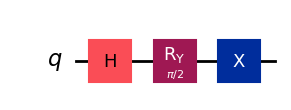

In [ ]:
n_qubits = 1
qc = QuantumCircuit(n_qubits)
qc.add_H_gate(0)
qc.add_RY_gate(0, np.pi / 2)
qc.add_X_gate(0)

qc = convert_circuit(qc)  # qiskitにコンバート
qc.draw("mpl")

In [ ]:
#回路出力用
def print_circuit(qc):
    from quri_parts.qiskit.circuit import convert_circuit
    qc_qiskit = convert_circuit(qc)
    return qc_qiskit.draw("mpl")

#latex表示をする為の処理
def visualize_latex(qc):
    # 状態ベクトルの取得
    from quri_parts.qiskit.circuit import convert_circuit
    from qiskit.quantum_info import Statevector
    #qc_qiskit = convert_circuit(qc)
    return Statevector(qc).draw('latex')

## 問題1 重ね合わせ状態の作成
1量子ビットに対して次の量子状態:

$$
\frac{1}{\sqrt{2}}(\ket{0}+i\ket{1})
$$

を作成せよ

In [ ]:
n_qubits = 1
# 量子回路の作成
qc = QuantumCircuit(n_qubits)
##################
### EDIT BELOW ###
##################

qc.add_H_gate(0)
qc.add_U1_gate(0,np.pi / 2.0)

##################
### EDIT ABOVE ###
##################
qc = convert_circuit(qc)
visualize_latex(qc)

<IPython.core.display.Latex object>

## 問題2 エンタングル状態の作成
2量子ビットに対して次の量子状態:
$$
\begin{align*}
&\frac{1}{\sqrt{2}}(\ket{0}\ket{1}-\ket{1}\ket{0})\\
=&\frac{1}{\sqrt{2}}(\ket{1}-\ket{2})
\end{align*}
$$
を作成せよ

In [ ]:
n_qubits = 2
# 量子回路の作成
qc = QuantumCircuit(n_qubits)
##################
### EDIT BELOW ###
##################

qc.add_H_gate(1)
qc.add_CNOT_gate(1, 0)
qc.add_X_gate(1)
qc.add_Z_gate(1)
##################
### EDIT ABOVE ###
##################
qc = convert_circuit(qc)
visualize_latex(qc)

<IPython.core.display.Latex object>

# 問題3 古典論理回路の再現

### AND (0,1がregisterで2が出力結果)
$$
\begin{align*}
\ket{000}\to\ket{000}\\
\ket{001}\to\ket{001}\\
\ket{010}\to\ket{010}\\
\ket{011}\to\ket{111}\\
\end{align*}
$$

In [ ]:
n_qubits = 3
# 量子回路の作成
qc = QuantumCircuit(n_qubits)
##################
### EDIT BELOW ###
##################

#ここはレジスター
qc.add_X_gate(0)
qc.add_X_gate(1)

#本体
qc.add_TOFFOLI_gate(0, 1, 2)

##################
### EDIT ABOVE ###
##################
qc = convert_circuit(qc)
visualize_latex(qc)


<IPython.core.display.Latex object>


### OR (0,1がregisterで2が出力結果)
$$
\begin{align*}
\ket{000}\to\ket{000}\\
\ket{001}\to\ket{101}\\
\ket{010}\to\ket{110}\\
\ket{011}\to\ket{111}\\
\end{align*}
$$

In [ ]:
n_qubits = 3
# 量子回路の作成
qc = QuantumCircuit(n_qubits)
##################
### EDIT BELOW ###
##################

#ここはレジスター
qc.add_X_gate(0)
qc.add_X_gate(1)


qc.add_CNOT_gate(0, 2)
qc.add_CNOT_gate(1, 2)
qc.add_TOFFOLI_gate(0, 1, 2)

##################
### EDIT ABOVE ###
##################
qc = convert_circuit(qc)
visualize_latex(qc)

<IPython.core.display.Latex object>

# 問題4 Equal Superpositionの作成
$N$量子ビットに対して次の量子状態
$$
\frac{1}{\sqrt{2^N}}\sum_{k=0}^{2^N-1}\ket{k}
$$
を作成せよ (以下では$N=3$)

In [ ]:
n_qubits = 3
# 量子回路の作成
qc = QuantumCircuit(n_qubits)
##################
### EDIT BELOW ###
##################

for k in range(n_qubits):
    qc.add_H_gate(k)

##################
### EDIT ABOVE ###
##################
qc = convert_circuit(qc)
visualize_latex(qc)

<IPython.core.display.Latex object>

# 測定について

In [ ]:
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler

n_qubits = 3
# 量子回路の作成
qc = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    qc.add_H_gate(i)
qc.add_CNOT_gate(1, 0)
qc.add_X_gate(1)
qc.add_Z_gate(1)

# Create the sampler
sampler = create_qulacs_vector_sampler()
sampling_result = sampler(qc, shots=1000)
print(sampling_result)

Counter({7: 137, 4: 132, 3: 131, 0: 125, 1: 124, 2: 123, 5: 123, 6: 105})


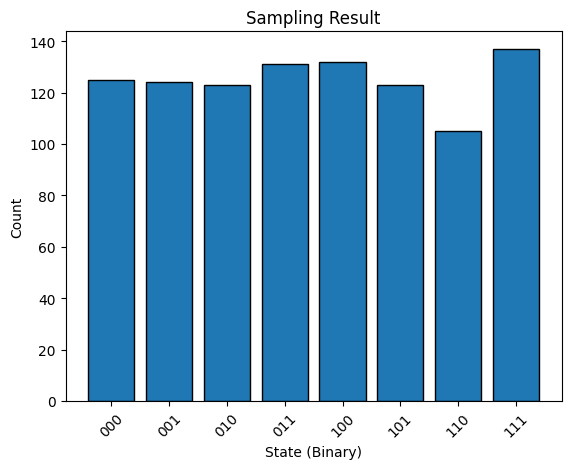

In [ ]:
def show_sample_result(data, n_qubits):
    import matplotlib.pyplot as plt

    # データをキーでソート
    sorted_data = dict(sorted(data.items()))

    # キーと値を別々のリストに分ける
    keys = list(sorted_data.keys())
    values = list(sorted_data.values())

    # キーをn_qubitsに応じた桁数の二進数表記に変換
    bin_keys = [format(key, f'0{n_qubits}b') for key in keys]

    # ヒストグラムのプロット
    plt.bar(bin_keys, values, edgecolor='black')

    # グラフのタイトルとラベル
    plt.title('Sampling Result')
    plt.xlabel('State (Binary)')
    plt.ylabel('Count')

    # x軸の目盛りを45度回転
    plt.xticks(rotation=45)

    # グラフの表示
    plt.show()
show_sample_result(sampling_result, n_qubits)


# 物理量の期待値の計算

量子ゲート U により状態
$$
\ket{\psi} = U\ket{0}
$$
を作成し、物理量の期待値
$$
\bra{\psi}O\ket{\psi}
$$
を計算してみます

In [ ]:
from quri_parts.core.operator import Operator, pauli_label
from quri_parts.qulacs.estimator import create_qulacs_vector_estimator
from quri_parts.core.state import quantum_state

## 物理量(オブザーバブル)の作成

In [ ]:
n_qubits = 3
op = Operator()
op.add_term(pauli_label("Z0 Z1 Z2"), 2) #Pauli行列を文字列として渡せばオブザーバブルになる
op.add_term(pauli_label("X0 Y1 Z2"), -1)
for k in range(n_qubits):
    op.add_term(pauli_label(f"Y{k}"), 1)
print(op)

2*Z0 Z1 Z2 + -1*X0 Y1 Z2 + 1*Y0 + 1*Y1 + 1*Y2


In [ ]:
n_qubits = 3
# 量子回路の作成
qc = QuantumCircuit(n_qubits)

#適当な状態を作成
qc.add_X_gate(0)
qc.add_X_gate(1)

state = quantum_state(n_qubits, circuit=qc)

qc = convert_circuit(qc)
visualize_latex(qc)

<IPython.core.display.Latex object>

In [ ]:
estimator = create_qulacs_vector_estimator() # Estimatorを作成 今回はqulacsを使用
estimate = estimator(op, state) # 演算子(オブザーバブル)と状態を渡す

# 戻り値には推定された期待値と、誤差が含まれる
print(f"Estimated expectation value: {estimate.value}")
# (サンプリングではなく状態ベクトルのシミュレーションの場合、誤差は0になる)
print(f"Estimation error: {estimate.error}")

Estimated expectation value: (2+0j)
Estimation error: 0.0


# 問題5 Ising model のエネルギーの計算
Ising modelのハミルトニアン:
$$
H = -\sum_{k=0}^{N-1} Z_iZ_{i+1}
$$
を作成(N=4)し、

状態$\ket{\psi}$がそれぞれ$\ket{0101}$, $\ket{0000}$, $\ket{1111}$ の時の期待値 $\bra{\psi}H\ket{\psi}$ を計算し、結果を考察せよ

In [ ]:
n_qubits = 4
op = Operator()
##################
### EDIT BELOW ###
##################

for i in range(n_qubits-1):
    op.add_term(pauli_label(f"Z{i} Z{i+1}"), -1)

op.add_term(pauli_label(f"Z{0} Z{n_qubits-1}"), -1)

##################
### EDIT ABOVE ###
##################
print(op)

-1*Z0 Z1 + -1*Z1 Z2 + -1*Z2 Z3 + -1*Z0 Z3


In [ ]:
qc = QuantumCircuit(n_qubits)

#状態を作成
##################
### EDIT BELOW ###
##################

qc.add_X_gate(0)
qc.add_X_gate(1)
qc.add_X_gate(2)
qc.add_X_gate(3)

##################
### EDIT ABOVE ###
##################



state = quantum_state(n_qubits, circuit=qc)
estimator = create_qulacs_vector_estimator() # Estimatorを作成 今回はqulacsを使用
estimate = estimator(op, state) # 演算子(オブザーバブル)と状態を渡す

# 戻り値には推定された期待値と、誤差が含まれる
print(f"Estimated expectation value: {estimate.value}")
# (サンプリングではなく状態ベクトルのシミュレーションの場合、誤差は0になる)
print(f"Estimation error: {estimate.error}")

Estimated expectation value: (-4+0j)
Estimation error: 0.0
